In [79]:
import time
import os 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt 
os.chdir(r'c:/users/vasil/desktop/parsing_data')
import pandas as pd
import numpy as np
from operator import itemgetter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Flatten, Embedding, GlobalMaxPool1D, Dropout,SpatialDropout1D, LSTM, Bidirectional, Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers.recurrent import GRU
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
import pickle


In [80]:
def clear(txt):
    tokens=[morph.parse(w)[0].normal_form for w in txt.split()]
    tbl=str.maketrans('', '',string.punctuation)
    stripped=[w.translate(tbl) for w in tokens]
    stop_words = stopwords.words('russian')                                                               
    words=[word for word in stripped if word.isalpha() and word not in stop_words] 
    return str(words)

data = pd.read_csv('clean_data_1.csv', sep=';', encoding='windows-1251')
data = data.drop('Unnamed: 0', axis=1)
labels = data.loc[:,'salary':'court_threat'].astype('category')
data['text'] = data['text'].map(lambda x: clear(str(x)))
num_labels = 7



tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(data['text'])
vocab_size = len(tokenizer.word_index)+1

In [81]:

counts = []
for category in list(data.columns.values)[1:]:
    counts.append(data[category].sum())
  
class_weights={
    0: 1.0/counts[0],
    1: 1.0/counts[1],
    2: 1.0/counts[2],
    3: 1.0/counts[3],
    4: 1.0/counts[4],
    5: 1.0/counts[5],
    6: 1.0/counts[6],
}

In [82]:
x_train, x_test,y_train, y_test = train_test_split(data['text'], labels, random_state=42, test_size=0.2, shuffle=True)

In [83]:
sequences_train = tokenizer.texts_to_sequences(x_train)
train_x = np.array(pad_sequences(sequences_train, maxlen=90))

sequences_train_1 = tokenizer.texts_to_sequences(x_test)
test_x = np.array(pad_sequences(sequences_train_1, maxlen=90))

In [84]:
epochs = 100
batch_size = 64
n_words_to_skip = 50
pad_type = trunc_type = 'pre'
drop_embed = 0.2
n_dense = 256
dropout = 0.2
n_conv = 256
k_conv = 3
embedding_dim = 300

In [89]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length = 90, trainable=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(7,activation='sigmoid'))

In [93]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 90, 300)           1087500   
_________________________________________________________________
dropout_8 (Dropout)          (None, 90, 300)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 707       
Total params: 1,248,607
Trainable params: 1,248,607
Non-trainable params: 0
_________________________________________________________________


In [71]:
#new
model = Sequential()
emb = Embedding(vocab_size, embedding_dim,input_length = 90, trainable=True)

model.add(emb)
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D()) 
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D()) 
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D())  # global max pooling
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='sigmoid'))

In [8]:
model = Sequential() # лучшая
model.add(Embedding(vocab_size, embedding_dim,input_length = 90, trainable=True))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
#model.add(MaxPooling1D()) 
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Dense(7, activation='sigmoid'))

In [90]:
model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=['categorical_accuracy'])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='Convolutional.h5', save_best_only=True)
]


In [91]:
history = model.fit(train_x, y_train, class_weight=class_weights, batch_size=batch_size, epochs=epochs, 
    verbose=1, validation_split=.1,
    callbacks=callbacks)

Train on 440 samples, validate on 49 samples
Epoch 1/100
440/440 [==============================] - 7s 16ms/step - loss: 0.0047 - categorical_accuracy: 0.1818 - val_loss: 0.0037 - val_categorical_accuracy: 0.2245
Epoch 2/100
440/440 [==============================] - 4s 8ms/step - loss: 0.0041 - categorical_accuracy: 0.1045 - val_loss: 0.0036 - val_categorical_accuracy: 0.1020
Epoch 3/100
440/440 [==============================] - 4s 8ms/step - loss: 0.0039 - categorical_accuracy: 0.2864 - val_loss: 0.0033 - val_categorical_accuracy: 0.4898
Epoch 4/100
440/440 [==============================] - 4s 8ms/step - loss: 0.0036 - categorical_accuracy: 0.4091 - val_loss: 0.0034 - val_categorical_accuracy: 0.3265
Epoch 5/100
440/440 [==============================] - 4s 8ms/step - loss: 0.0031 - categorical_accuracy: 0.4909 - val_loss: 0.0032 - val_categorical_accuracy: 0.3061
Epoch 6/100
440/440 [==============================] - 4s 8ms/step - loss: 0.0023 - categorical_accuracy: 0.6818 - val_

In [7]:
model = Sequential()
emb = Embedding(vocab_size, embedding_dim,input_length = 90, trainable=True)
model.add(emb)
#model.add(SpatialDropout1D(drop_embed)) # при сверточной было 0.2
#model.add(Conv1D(n_conv, k_conv, activation='relu'))
#model.add(GlobalMaxPool1D())
#model.add(Dense(n_dense, activation='relu'))
#model.add(Dropout(dropout))
model.add(Dropout(0.15))
model.add(GlobalMaxPool1D())
model.add(Dense(7, activation='sigmoid'))
#model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#model.add(Dense(7, activation='sigmoid'))




In [11]:
# creates a HDF5 file 'my_model.h5'
model.model.save('working_model.h5')
 
# Save Tokenizer i.e. Vocabulary
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\vasil\Anaconda3\envs\dp\lib\site-packages\keras\engine\sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [3]:
model = load_model('working_model.h5')
 
# load tokenizer
tokenizer = Tokenizer()
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [24]:
inp_txt = 'Начальник мудак и зарплата маленькая'
clean_inp = clear(inp_txt)
textArray = np.array(pad_sequences(tokenizer.texts_to_sequences([clean_inp]), maxlen=90))

In [28]:
model.evaluate(train_x, y_train)

489/489 [==============================] - 0s 179us/step


[0.04863647211548741, 0.8159509203063442]

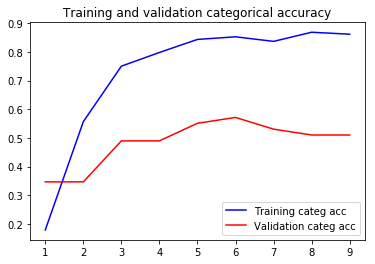

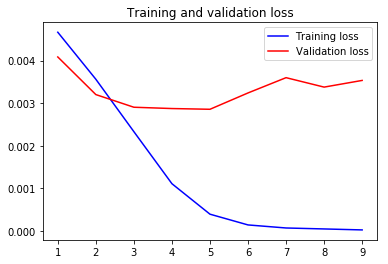

In [76]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training categ acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation categ acc')
plt.title('Training and validation categorical accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b',  label='Training loss')
plt.plot(epochs, val_loss, 'b',color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['categorical_accuracy'])
    return model

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[len(tokenizer.word_index)+1], 
                  embedding_dim=[50],
                  maxlen=[100])
#vocab_size = len(tokenizer.word_index)+1

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100

In [ ]:
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)